In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [8,6]

In [2]:
#First we define as few variables
N = 200 #resolution
delta = 2*np.pi/N #Spacing between points

def normalize(wavefunction):
    normalized_wavefunction = 1/np.sqrt(delta * (wavefunction.T)@(np.conj(wavefunction))) * wavefunction
    #normalized_wavefunction = 1/np.sqrt((wavefunction.T)@(np.conj(wavefunction))) * wavefunction
    return normalized_wavefunction

# E1
#### a) Defining a sparse matrix that is elementwise cosine

In [3]:
#Defining the phi values, this is essentially our potential
phi = np.linspace(-np.pi, np.pi, N)

cosMatrix = np.diag(np.cos(phi))


#### b) The $q^2$ matrix

In [4]:
diagArr = np.ones(N)
offDiagArr = np.ones(N-1)

q2Matrix = 1/delta**2 * (2*np.diag(diagArr) - np.diag(offDiagArr, k = 1) - np.diag(offDiagArr, k = -1))
q2Matrix[1][N-1], q2Matrix[N-1][1] = -1/delta**2, -1/delta**2  #Periodic boundary conditions

#### c) The tunable transmon Hamiltonian
The Hamiltonian is given by equation (22) from "A Qunatum Engineer's Guide to Superconducting Qubits" and is 
$$H=4E_Cn^2-E_J\sqrt{\cos(\varphi_e)^2+d^2\sin(\varphi_e)^2}\cos(\varphi)$$

In [5]:
#Defining a function that returns the Hamiltonian, which is the sum of the potential and kinetic energy and the energy scale which will be used for plotting later
def hamiltonian(E_C, E_J, phi_e):
    E_kin = 4*E_C*q2Matrix
    E_pot = -E_J*np.abs(np.cos(phi_e))*cosMatrix
    return E_kin + E_pot, E_J*np.cos(phi_e)

#### d) Computing the eigenvalues and eigen vectors

Before being able to compute the wavefunctions and recreate Fig. 1a then we need to find the right parameters. On page 9 in the circuitQ paper we see that the Josephson energy is $E_J=9.69 GHz\cdot h$ and the capacitance is $C=100fF$, which using $E_C=e^2/2C$ we find that $E_C=0.194GHz\cdot h$

In [6]:
H, scale = hamiltonian(0.194, 9.69, phi_e=0)

#k is number of eigenvalues and eigenvectors it finds and SR it means that it finds the pairs that have the eigenvalues with the smallest real part
eigenvalues, eigenvectors = sc.sparse.linalg.eigsh(H, k=7, which = "SA")  #The eigenvalues are in units of GHz*h

for i in range(7):
    print(eigenvalues[i])


-36.09039377589591
-7.791857942449495
-4.102780540637003
-0.6393623869272282
2.5708376067781153
5.522721825791763
8.172662457817678


-7.791857942449495
-4.102780540637003
-0.6393623869272282
2.5708376067781153
5.522721825791763


Text(0.5, 1.0, 'Transmon spectrum')

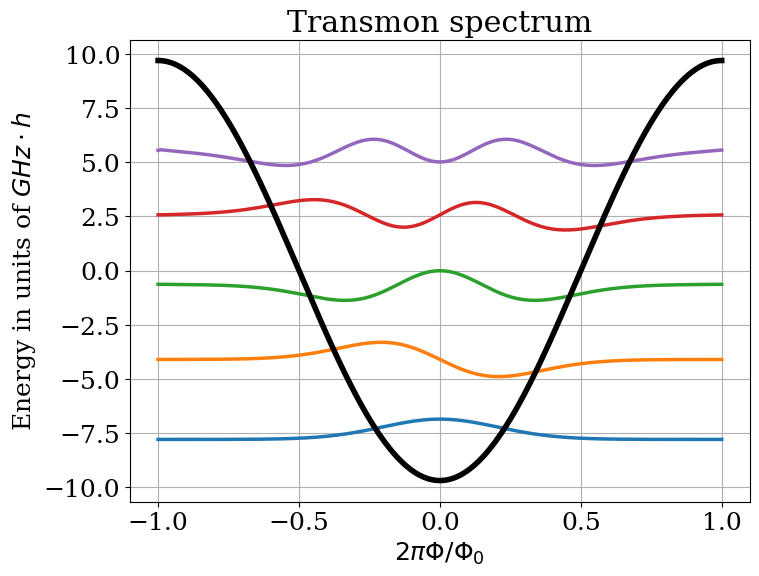

In [7]:
#We can then plot our potential and our wavefunctions

for i in range(1, 6):
    plt.plot(phi/np.pi, -normalize(eigenvectors[:,i]) + eigenvalues.real[i], linewidth = 2.5)
    print(eigenvalues[i])

plt.plot(phi/np.pi, -scale*np.cos(phi), linewidth = 4, color="black")

plt.xlabel("$2\pi \Phi/\Phi_0$")
plt.ylabel(r"Energy in units of $GHz\cdot h$")
plt.title("Transmon spectrum")

#### Frequency as function of external flux
I do this to see if everythong behaves as expected and the result looks like Fig.b in qunatum engineers guide.

Text(0, 0.5, '$\\omega$ in $GHz$')

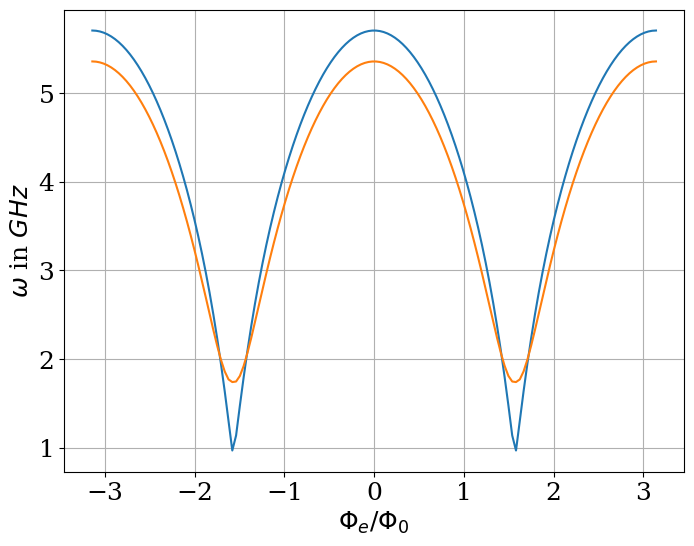

In [8]:
E_J, E_C = 15, 0.3

phi_e_arr = np.linspace(-np.pi, np.pi, 150)

freq = np.zeros_like(phi_e_arr)
freq2 = np.zeros_like(phi_e_arr)

for i in range(150):
    ham, scale = hamiltonian(0.3, 15, phi_e_arr[i])
    
    energy, state = sc.sparse.linalg.eigsh(ham, k=6, which = "SA")  #Solve the hamiltonian
    freq[i] = energy[2]- energy[1]
    freq2[i] = energy[3]- energy[2]

plt.plot(phi_e_arr, freq)
plt.plot(phi_e_arr, freq2)
plt.xlabel(r"$\Phi_e/\Phi_0$")
plt.ylabel(r"$\omega$ in $GHz$")

# E2)

To find the relaxation time well use equation (54) from from "A Qunatum Engineer's Guide to Superconducting Qubits"
$$\Gamma_1=\frac{1}{\hbar^2} |\bra{0}\frac{\partial H}{\partial \lambda}\ket{1} |^2 S(\omega_q)$$

Let us start by finding the flux noise
$$\frac{\partial H}{\partial \varphi_e}=E_J\frac{(d^2-1)\sin(\varphi_e)\cos(\varphi_e)}{\sqrt{\cos(\varphi_e)^2+d^2\sin(\varphi_e)^2}}$$

But for simplicity we start by setting $d=0$ and get
$$\frac{\partial H}{\partial \Phi_e}=E_J\left(\frac{2\pi}{\Phi_0}\right)\sin\left(\frac{2\pi}{\Phi_0}\Phi_e\right)\cos(\phi)$$

In [9]:
phi_e = np.linspace(-np.pi, np.pi, 200)

qubit_frequency= np.zeros_like(phi_e)
flux_relaxation_arr = np.zeros_like(phi_e)


A_flux=1e-6

def spectral(A, omega):
    return 2*np.pi * A**2 / np.abs(omega)

for i in range(len(phi_e)):
    Ham, scale = hamiltonian(0.3, 15, phi_e[i]) #Define the hamiltonian with E_J=15 and E_C=0.3
    energy, state = sc.sparse.linalg.eigsh(Ham, k=5, which = "SA")  #Solve the hamiltonian

    flux_relaxation_arr[i] =15**2 * (4*np.pi)**2 * (A_flux)**2 * np.abs(normalize(eigenvectors[:,0])@cosMatrix@normalize(eigenvectors[:,1]))**2 * np.sin(phi_e[i])**2 * 1/(energy[2]-energy[1])* 10**9 #Calculate the Gamma_1 frequency
    
    qubit_frequency[i] = energy[2]-energy[1]

print(energy[2]-energy[1])

5.707876909163728


Text(0, 0.5, '$\\Gamma_1$ in $Hz$')

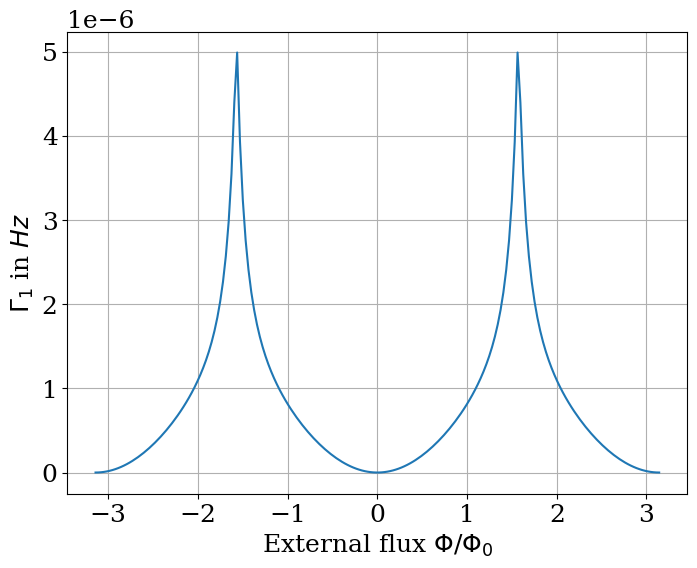

In [10]:
plt.plot(phi_e, flux_relaxation_arr)

#plt.xticks(ticks=np.linspace(0,np.pi, 9), labels=["0", r"$\pi/8$",r"$\pi/4$", r"$3\pi/8$", r"$\pi/2$", r"$5\pi/8$", r"$3\pi/4$", r"$7\pi/8$", r"$\pi$"])
plt.xlabel(r"External flux $\Phi/\Phi_0$")
plt.ylabel("$\Gamma_1$ in $Hz$")


There sweet spots at 0 and $\pi$ as expected from fig. 2 in quantum engineers guide. Something about the axis is of. For a $T_1\approx 10\mu s$ then $\Gamma_1\approx 10^{5}Hz$. So I'm roughly a factor $GHz$ i.e. $10^9$ from a sensible result.

For the charge noise we need to define the $q$ matrix

Text(0.5, 0, '$\\varphi_e$')

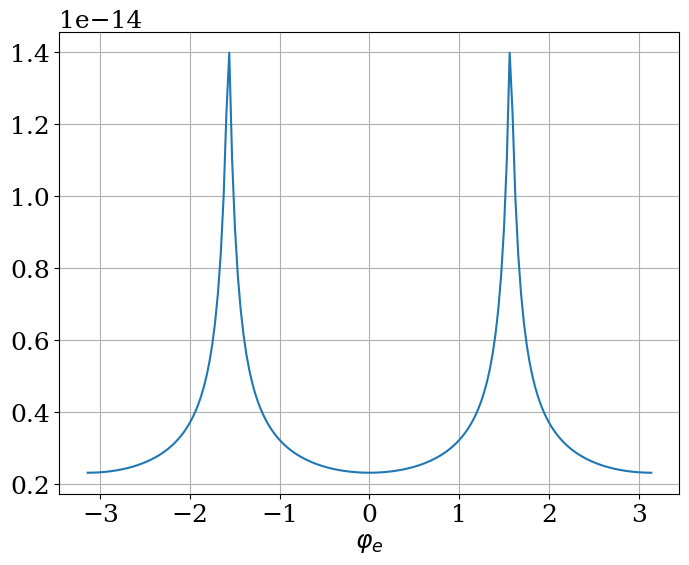

In [11]:
qMatrix = -1j/(2*delta) * (np.diag(offDiagArr, k = 1) - np.diag(offDiagArr, k = -1))

A_charge = 1e-4

charge_relaxation_arr =np.zeros_like(phi_e)
driving_frequency_charge = np.zeros_like(phi_e)



for i in range(len(phi_e)):
    Ham, scale = hamiltonian(1, 50, phi_e[i])
    energy, state = sc.sparse.linalg.eigsh(Ham, k=5, which = "SA")  
    driving_frequency_charge[i] = energy[1]-energy[0]

    charge_relaxation_arr[i] =64 * np.abs(eigenvectors[:,0]@qMatrix@eigenvectors[:,1])**2 * spectral(A_charge, energy[2]-energy[1])


plt.plot(phi_e, charge_relaxation_arr)
plt.xlabel("$\\varphi_e$")

### c) Ohmic noise

In [12]:
ohmic_relaxation_arr = np.zeros(125)


#B_ohmic = 5.2e-9
A_ohmic = 1e-4

#Loops over E_J/E_C
for i in range(125):
    Ham, scale = hamiltonian(1, i, 0)
    energy, state = sc.sparse.linalg.eigsh(Ham, k=6, which = "SA")  
    driving_frequency_charge[i] = energy[1]-energy[0]

    ohmic_relaxation_arr[i] =64*np.abs( eigenvectors[:,0]@qMatrix@eigenvectors[:,1])**2 * A_ohmic**2 * (2*np.pi)**2/(energy[2]-energy[1])


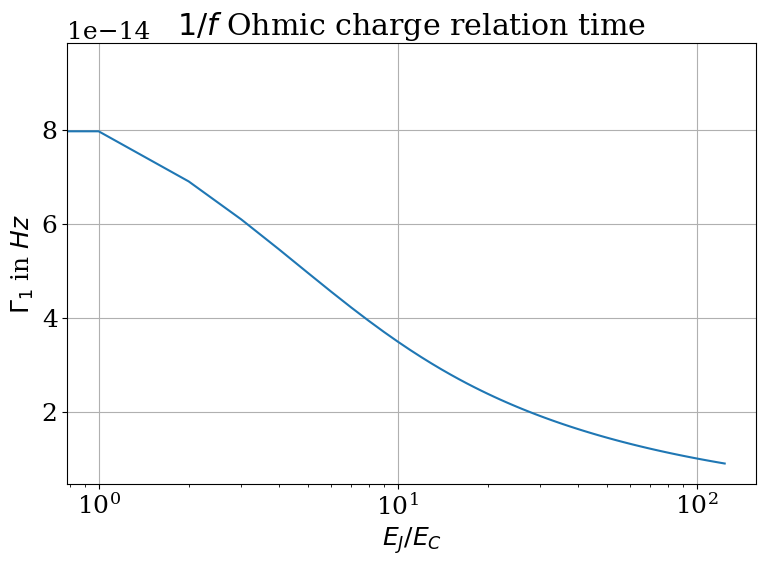

In [13]:
plt.plot(range(125), ohmic_relaxation_arr)
plt.xlabel(r"$E_J/E_C$")
plt.ylabel("$\Gamma_1$ in $Hz$")
#plt.yscale('log')
plt.xscale('log')
plt.title(r"$1/f$ Ohmic charge relation time")
plt.tight_layout()

# E3)